In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os, shutil
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import random_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import kagglehub
import os, glob
quick_draw_path = kagglehub.dataset_download('emiliuz/quick-draw-subset')
quick_draw_path = glob.glob(os.path.join(quick_draw_path, "*"))[0]
print('Data source import complete.')


100%|██████████| 21.9M/21.9M [00:00<00:00, 177MB/s]

Extracting files...


Data source import complete.


In [ ]:
classes = sorted([
    "airplane",
    "apple",
    "axe",
    "banana",
    "bicycle",
    "bird",
    "birthday cake",
    "book",
    "bowtie",
    "bucket",
    "bus",
    "butterfly",
    "camera",
    "candle",
    "canoe",
    "car",
    "cat",
    "chair",
    "clock",
    "cloud",
    "computer",
    "cup",
    "diamond",
    "dog",
    "door",
    "envelope",
    "eyeglasses",
    "face",
    "fish",
    "hat",
    "house",
    "ice cream",
    "ladder",
    "light bulb",
    "lollipop",
    "pizza",
    "star",
    "television",
    "tornado",
    "tree"
])

for folder_name in os.listdir(quick_draw_path):
  folder_path = os.path.join(quick_draw_path, folder_name)
  if os.path.isdir(folder_path) and folder_name not in classes:
    shutil.rmtree(folder_path)

In [ ]:
quick_draw_path

'/root/.cache/kagglehub/datasets/emiliuz/quick-draw-subset/versions/1/quick_draw_subset'

In [ ]:
for folder in os.listdir(quick_draw_path):
  print(folder)

cloud
ice cream
chair
canoe
candle
light bulb
eyeglasses
lollipop
banana
computer
tornado
cat
bicycle
apple
bus
tree
house
pizza
axe
diamond
cup
bowtie
door
hat
dog
birthday cake
ladder
fish
camera
book
clock
bucket
airplane
envelope
face
star
television
butterfly
car
bird


## Load the Data

In [ ]:
## 1. Data Transforms
data_transforms = {
    "train": transforms.Compose([
    transforms.Resize(384),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet mean for RGB
    std=[0.229, 0.224, 0.225]    # ImageNet std for RGB
    )
]),
    "val" : transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],  # ImageNet mean for RGB
    std=[0.229, 0.224, 0.225]    # ImageNet std for RGB
    )
])
}
data_dir = quick_draw_path
image_dataset = datasets.ImageFolder(root = data_dir, transform = data_transforms["train"])

train_set, val_set = random_split(image_dataset, [0.8,0.2])
train_set.transform = data_transforms["train"]
val_set.transform = data_transforms["val"]

image_datasets = {
    "train": train_set,
    "val": val_set
}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle = True)
for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_dataset.classes

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")


Using Device: cpu


In [ ]:
with open('classes.txt','a') as f:
  for name in class_names:
    f.write(name+"\n")

with open('classes.txt','r') as f:
  print(f.read())

airplane
apple
axe
banana
bicycle
bird
birthday cake
book
bowtie
bucket
bus
butterfly
camera
candle
canoe
car
cat
chair
clock
cloud
computer
cup
diamond
dog
door
envelope
eyeglasses
face
fish
hat
house
ice cream
ladder
light bulb
lollipop
pizza
star
television
tornado
tree



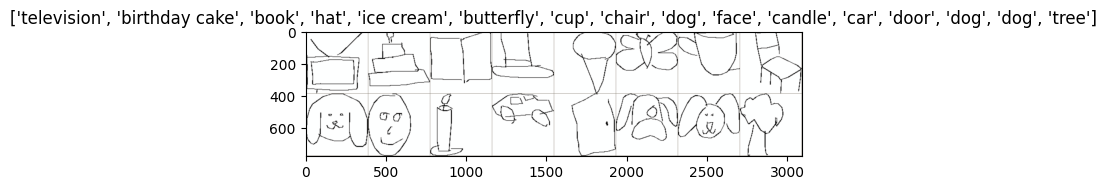

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training Loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
# Visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Loading Model

In [ ]:
import torch
import torch.nn as nn


class PatchEmbed(nn.Module):
    """Split image into patches and then embed them.

    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).

    patch_size : int
        Size of the patch (it is a square).

    in_chans : int
        Number of input channels.

    embed_dim : int
        The emmbedding dimension.

    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.

    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2


        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches, embed_dim)`.
        """
        x = self.proj(
                x
            )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        return x


class Attention(nn.Module):
    """Attention mechanism.

    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.

    n_heads : int
        Number of attention heads.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    attn_p : float
        Dropout probability applied to the query, key and value tensors.

    proj_p : float
        Dropout probability applied to the output tensor.


    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.

    qkv : nn.Linear
        Linear projection for the query, key and value.

    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.

    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x


class MLP(nn.Module):
    """Multilayer perceptron.

    Parameters
    ----------
    in_features : int
        Number of input features.

    hidden_features : int
        Number of nodes in the hidden layer.

    out_features : int
        Number of output features.

    p : float
        Dropout probability.

    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.

    act : nn.GELU
        GELU activation function.

    fc2 : nn.Linear
        The second linear layer.

    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

        return x


class Block(nn.Module):
    """Transformer block.

    Parameters
    ----------
    dim : int
        Embeddinig dimension.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.

    attn : Attention
        Attention module.

    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.

        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.

    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).

    patch_size : int
        Both height and the width of the patch (it is a square).

    in_chans : int
        Number of input channels.

    n_classes : int
        Number of classes.

    embed_dim : int
        Dimensionality of the token/patch embeddings.

    depth : int
        Number of blocks.

    n_heads : int
        Number of attention heads.

    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.

    qkv_bias : bool
        If True then we include bias to the query, key and value projections.

    p, attn_p : float
        Dropout probability.

    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.

    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.

    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.

    pos_drop : nn.Dropout
        Dropout layer.

    blocks : nn.ModuleList
        List of `Block` modules.

    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            qkv_bias=True,
            p=0.,
            attn_p=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbed(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(
                torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    p=p,
                    attn_p=attn_p,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)


    def forward(self, x):
        """Run the forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.

        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(
                n_samples, -1, -1
        )  # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]  # just the CLS token
        x = self.head(cls_token_final)

        return x

## Loading Pre trained Weigths

In [ ]:
!pip install timm -qqq

import timm

model_name = "vit_base_patch16_384"
model_official = timm.create_model(model_name, pretrained=True)
model_official.eval()
print(type(model_official))

# Save the model weights
torch.save(model_official.state_dict(), "model.pth")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
<class 'timm.models.vision_transformer.VisionTransformer'>


In [ ]:
model_ft = VisionTransformer()
model_ft.load_state_dict(torch.load('model.pth', weights_only = True))
for param in model_ft.parameters():
  param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_ft.head.in_features

model_ft.head = torch.nn.Linear(in_features = num_ftrs, out_features = len(class_names))

model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()

# only parameters of final layer are being optimized
optimizer = optim.Adam(model_ft.head.parameters(), lr = 0.001)

# Decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs = 10)

Epoch 0/9
----------
train Loss: 2.8251 Acc: 0.3938
val Loss: 1.8510 Acc: 0.5275

Epoch 1/9
----------
train Loss: 1.5411 Acc: 0.6100
val Loss: 1.4813 Acc: 0.6212

Epoch 2/9
----------
train Loss: 1.2280 Acc: 0.6815
val Loss: 1.1882 Acc: 0.6907

Epoch 3/9
----------
train Loss: 1.0755 Acc: 0.7247
val Loss: 1.3157 Acc: 0.6956

Epoch 4/9
----------
train Loss: 1.0190 Acc: 0.7379
val Loss: 1.1818 Acc: 0.7066

Epoch 5/9
----------
train Loss: 0.9191 Acc: 0.7631
val Loss: 1.1269 Acc: 0.7280

Epoch 6/9
----------
train Loss: 0.8875 Acc: 0.7700
val Loss: 1.2323 Acc: 0.7324

Epoch 7/9
----------
train Loss: 0.2684 Acc: 0.9210
val Loss: 0.4597 Acc: 0.8753

Epoch 8/9
----------
train Loss: 0.2166 Acc: 0.9319
val Loss: 0.4577 Acc: 0.8747

Epoch 9/9
----------
train Loss: 0.2096 Acc: 0.9347
val Loss: 0.4712 Acc: 0.8695

Training complete in 124m 28s
Best val Acc: 0.875275


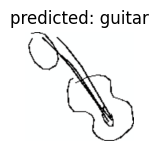

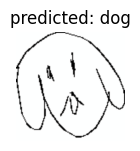

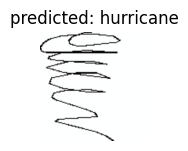

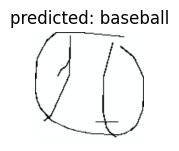

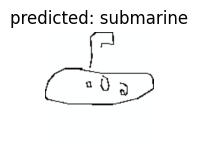

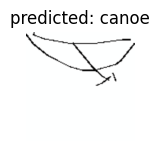

In [ ]:
visualize_model(model_ft)

plt.ioff()
plt.show()

## Save models parameters

In [ ]:
torch.save(model_ft.state_dict(), "vit_quick_draw_ft.pth")

## Saving Model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'vit_quick_draw_ft.pth'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model_ft.state_dict(), path)